<a href="https://colab.research.google.com/github/Sirsirious/NLPTools/blob/master/SentimentAnalysisComparisons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Utilizando os arquivos: "imdb_labelled.txt", "amazon_cells_labelled.txt", "yelp_labelled.txt", "Youtube01-Psy.csv", "Youtube04-Eminem" e "Youtube05-Shakira" criar uma solução baseada em inteligencia artificial para realizar análise de sentimentos, classificando os comentários como Positivo, Negativo e Neutro


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import re
from collections import defaultdict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

Apresentar a taxa de acerto do modelo, Verdadeiro Positivo, Verdadeiro Negativo, Falso Positivo e Falso Negativo.


Vou apresentar três métodos para realizar análise de sentimentos:

1. Análise Naïve baseada em distribuição de palavras.

1. Análise de sentimento simples com Regressão Logística

2. Análise de sentimento com redes Neurais Profundas (LSTM)

3. Análise de sentimento com mecanismos de Atenção (Attention)

# Ferramentas Gerais

Antes de iniciar o treinamento de modelos, serão feitas algumas etapas de pré-processamento.

In [ ]:
# Para começar, vamos juntar todos os datasets em uma mesma variável:
# Como usei o Google Colabs, os arquivos são armazenados na pasta /content/
# Basta incluir todos os arquivos nessa pasta.

# Dataset psy
yt_psy = pd.read_csv('/content/Youtube01-Psy.csv')
yt_psy = yt_psy.drop('COMMENT_ID', axis = 1)
yt_psy = yt_psy.drop('AUTHOR', axis = 1)
yt_psy = yt_psy.drop('DATE', axis = 1)
yt_psy= yt_psy.rename(columns={"CONTENT": "text", "CLASS": "label"})

# Dataset eminem
yt_eminem = pd.read_csv('/content/Youtube04-Eminem.csv')
yt_eminem = yt_eminem.drop('COMMENT_ID', axis = 1)
yt_eminem = yt_eminem.drop('AUTHOR', axis = 1)
yt_eminem = yt_eminem.drop('DATE', axis = 1)
yt_eminem= yt_eminem.rename(columns={"CONTENT": "text", "CLASS": "label"})

# Dataset shakira
yt_shakira = pd.read_csv('/content/Youtube05-Shakira.csv')
yt_shakira = yt_shakira.drop('COMMENT_ID', axis = 1)
yt_shakira = yt_shakira.drop('AUTHOR', axis = 1)
yt_shakira = yt_shakira.drop('DATE', axis = 1)
yt_shakira= yt_shakira.rename(columns={"CONTENT": "text", "CLASS": "label"})

# Dataset amazon
amazon = pd.read_csv('/content/amazon_cells_labelled.txt', sep='\t', header=None)
amazon.columns =['text', 'label']

# Dataset imdb
imdb = pd.read_csv('/content/imdb_labelled.txt', sep='\t', header=None)
imdb.columns =['text', 'label']

# Dataset yelp
yelp = pd.read_csv('/content/yelp_labelled.txt', sep='\t', header=None)
yelp.columns =['text', 'label']

frames = [yt_psy, yt_eminem, yt_shakira, amazon, imdb, yelp]
df = pd.concat(frames)
df.describe()

,label
count,3916.000000
mean,0.505618
std,0.500032
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


Pela descrição do conjunto de dados, logo se percebe que o dataset é balanceado, ou seja, cerca de metade dos textos é positiva e a outra metade negativa. Isso fica claro pela média ser em torno de meio (somando-se todos os labels e dividindo pela quantidade de entradas, obtém-se exatamente a metade entre 0 e 1).

Outro detalhe é que o dataset completo não é tão grande, com apenas 3916 entradas. Entretanto, deve ser suficiente para fazermos os testes iniciais. Antes, porém, façamos alguns preprocessamentos.

## Preprocessamento

As seguintes etapas de preprocessamento serão aplicadas:

1) converter em lowercase

2) separar texto da pontuação

3) remover espaços extras

4) remover urls

Outros passos podem ser tomados de acordo com o contexto, mas esses bastarão para uma análise sobre o presente conjunto de dados.

In [ ]:
df_preprocessed = df.copy()

# Transformar em lowercase
df_preprocessed['text'] = df['text'].apply(lambda x: x.lower())

# Separar texto da pontuação
text_pontuacao_pattern = "(\w)([\.!?:;,\)\(]+)(?![\)\(\[\]DPcom])"
df_preprocessed['text'] = df_preprocessed['text'].apply(lambda x: re.sub(text_pontuacao_pattern,"\g<1> \g<2>", x))

# Remover espaços extras
df_preprocessed['text'] = df_preprocessed['text'].apply(lambda x: re.sub('[\s\t]+',' ', x))

# Remover urls
url_regex_pattern = "(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})"
df_preprocessed['text'] = df_preprocessed['text'].apply(lambda x: re.sub(url_regex_pattern,'', x))

df_preprocessed

,text,label
0,"huh , anyway check out this you[tube] channel ...",1
1,hey guys check out my new channel and our firs...,1
2,just for test i have to say murdev.com,1
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,watch ?v=vtarggvgtwq check this out .﻿,1
...,...,...
995,i think food should have flavor and texture an...,0
996,appetite instantly gone .,0
997,overall i was not impressed and would not go b...,0
998,"the whole experience was underwhelming , and i...",0


## Preparando o vocabulário

Um ponto importante é preparar um dicionário com o vocabulário disponível no dataset.

In [ ]:
vocab = set()
for row in zip(df_preprocessed['text']):
    for w in row[0].split(" "):
        if w != '':
            vocab.add(w)
print(f"Número de palavras no vocabulário: {format(len(vocab))}")
print(f"Exemplo de 10 palavras: {list(vocab)[:10]}")

Número de palavras no vocabulário: 8203
Exemplo de 10 palavras: ['world\ufeff', '*****please', '.weebly', 'delicate', 'couple', 'focus', 'stretch', 'prophets', 'procedure', 'shops']


## Separação do dataset em base de teste e base de avaliação

Para poder fazer uma análise da eficiência real dos algoritmos, precisamos de separar o conjunto em uma base de teste e de avaliação. Faremos isso usando o método train_test_split do sklearn, deixando um total de 15% dos dados para avaliação (visto que temos poucos dados).

In [ ]:
random_state = 42
split_size = 0.15
train_data, test_data = train_test_split(df_preprocessed, test_size=split_size, random_state=random_state)
X_train = train_data['text']
y_train = train_data['label']
X_test = test_data['text']
y_test = test_data['label']
print(f"Tamanho do conjunto de treinamento: {len(X_train), len(y_train)}, Tamanho do conjunto de teste: {len(X_test), len(y_test)}")

Tamanho do conjunto de treinamento: (3328, 3328), Tamanho do conjunto de teste: (588, 588)


# Método 1: Análise inocente (Naïve)

Esse método é o mais simples e menos sofisticado. Consiste em criar uma tabela de "palavras positivas e palavras negativas". Ainda que não seja eficiente, serve como baseline - modelos que tiverem resultados piores que esse não podem ser considerados úteis.

O treinamento é simples: basta preencher uma tabela com a polaridade de cada palavra.

In [ ]:
# Cria-se um dicionário para armazenar a polaridade das palavras
weighted_vocab = defaultdict(lambda: defaultdict(int))
for text, label in zip(X_train, y_train):
    # Tokenização simples com split
    for word in text.split(" "):
        if word in vocab:
            weighted_vocab[word][label]+=1

# Criando um dicionário de pesos
normalized_weighted_vocab = {word: {"1":weighted_vocab[word][1]/(weighted_vocab[word][1]+weighted_vocab[word][0]), "0":weighted_vocab[word][0]/(weighted_vocab[word][1]+weighted_vocab[word][0])} for word in weighted_vocab}

In [ ]:
# Obtém-se a polaridade de cada expressão baseada na soma da polaridade das palavras:
def naive_sa(sentence, normalized_weighted_vocab):
    polarity_pos = 0
    polarity_neg = 0
    words = sentence.split(" ")
    for word in words:
        if word in normalized_weighted_vocab:
            polarity_pos += normalized_weighted_vocab[word].get("1", 0)
            polarity_neg += normalized_weighted_vocab[word].get("0", 0)
    return int(polarity_pos > polarity_neg)

Acurácia do Modelo Naïve: 0.7482993197278912


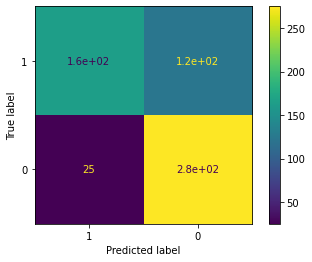

In [ ]:
# Calculando resultados na base de testes
y_test_hat_naive_sa = [naive_sa(text, normalized_weighted_vocab) for text in X_test]
# Acurácia na base de testes
naive_sa_results = y_test == y_test_hat_naive_sa
naive_sa_accuracy = np.average(naive_sa_results)
print(f"Acurácia do Modelo Naïve: {naive_sa_accuracy}")
confusion_matrix_naive_sa = confusion_matrix(y_test, y_test_hat_naive_sa)

from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_naive_sa,
                              display_labels=["1","0"])

disp = disp.plot()
plt.show()

Os resultados são melhores do que random-guessing (chutar 1 ou 0 para cada entrada, o que resultaria em uma acurácia média de 50%). Mas podemos melhorar.

# Método 2: Regressão Logística

A regressão logística é um método um pouco mais sofisticado que usa da aproximação de uma função logística para calcular o valor verdadeiro. Para usá-la, é necessário fazer um preprocessamento:

In [ ]:
def extract_features_logreg(text, freqs):
    # Tokenização simples
    word_l = text.split(" ")
    
    # Vetor de 2 elementos para: valor positivo, valor negativo
    x = np.zeros((1, 3)) 
    
    x[0,0] = 1

    for word in word_l:
        if word in freqs:
            # Contador positivos
            x[0,1] += freqs[word].get(1, 0)
            # Contador negativos
            x[0,2] += freqs[word].get(0, 0)
        
    assert(x.shape == (1, 3))
    return x

In [ ]:
X_train_logreg = np.array([extract_features_logreg(x, weighted_vocab) for x in X_train])
X_train_logreg = X_train_logreg.reshape((len(X_train),3))
X_train_logreg.shape

(3328, 1, 3)


(3328, 3)

In [ ]:
# Inicializamos o modelo com as opções default, visto que o dataset não possui nenhuma peculiaridade. 
# Apenas adicionamos o random_state para termos resultados iguais a cada execução.
logreg_model = LogisticRegression(random_state=random_state, fit_intercept=False, solver='liblinear')
logreg_model = logreg_model.fit(X_train_logreg, y_train)
logreg_model.score(X_train_logreg, y_train)

0.6739783653846154

Acurácia do Modelo Naïve: 0.673469387755102


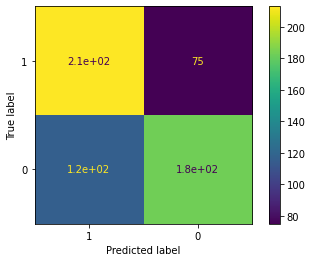

In [ ]:
X_test_logreg = np.array([extract_features_logreg(x, weighted_vocab) for x in X_test])
X_test_logreg = X_test_logreg.reshape((len(X_test),3))
y_test_hat_logreg = logreg_model.predict(X_test_logreg)
# Acurácia na base de testes
logreg_results = y_test == y_test_hat_logreg
logreg_accuracy = np.average(logreg_results)
print(f"Acurácia do Modelo Naïve: {logreg_accuracy}")
confusion_matrix_logreg = confusion_matrix(y_test, y_test_hat_logreg)
disp_logreg = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_logreg,
                              display_labels=["1","0"])

disp_logreg = disp_logreg.plot()
plt.show()

Vemos que a Regressão logística resultou em uma acurácia menor que o modelo Naïve. Isso significa que este modelo não é tão útil. 

Os motivos dos resultados piores talvez estejam relacionados à não normalização dos dados e também à não linearidade dos dados. Regressão logística não se dá bem com modelos não linearmente separáveis (que é o caso da maioria dos problemas de NLP).

# Método 3: Rede Neural Profunda

Iniciaremos com uma rede neural simples (apenas camadas densas) usando a bibliteca Keras.

Para isso, vamos usar algumas ferramentas do próprio keras para adptar o dataset para uso na biblioteca. Será usada a função de tokenizador.

Espera-se obter um resultado ligeiramente melhor que os anteriores usando essa função.

In [ ]:
# Delimita tamanho máximo de vocabulário
max_words = 10000

# Delimita tamanho máximo de sentença
max_len = 200

# Tokenizador, mais sofisticado que o simples string.split()
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_preprocessed['text'])

# Preparando sequencias de treinamento
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_train_preprocessed = tf.keras.preprocessing.sequence.pad_sequences(X_train_sequences, maxlen=max_len)

# Preparando sequencias de teste
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_preprocessed = tf.keras.preprocessing.sequence.pad_sequences(X_test_sequences, maxlen=max_len)


In [ ]:
# Criação de uma Rede Neural simples para análise de sentimento.
dense_model = tf.keras.Sequential()
# A camada embedding cria uma "tradução" de índices para vetores de valores em ponto flutuante. 
# Esses valores ajudam a representar sequências e podem capturar sintaxe e semântica de contexto.
# Por simplicidade, escolhi embeddings de dimensão 64
dense_model.add(tf.keras.layers.Embedding(max_words, 64, input_length=max_len))
# Para poder fazer a interligação da sequência com o modelo denso, é utilizada uma camada de "achatamento"
dense_model.add(tf.keras.layers.Flatten())
# Finalmente, um dos modos de se fazer a classificação é com uma camada Densa com a função sigmoide
# Essa função retorna um valor entre 0 e 1 - usaremos a aproximação desse valor como resultado
dense_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
# Compilação do modelo, usando o otimizador Adam, loss como binary crossentropy (2 classes) e a acurácia como métrica.
dense_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Essa configuração permitirá reduzir a Learning Rate à medida que o modelo aprende, evitando overfitting.
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Essa configuração fará com que o modelo pare de treinar caso o validation loss não reduza após 10 rodadas (mínimo local)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Treinamos o modelo - deve parar por volta da 19ª rodada, pois com poucos dados o modelo não 
# consegue generalizar o suficiente e para de melhorar por volta da 9ª rodada.
dense_model_history = dense_model.fit(X_train_preprocessed, y_train, batch_size=64, epochs=30,
                                      validation_data=(X_test_preprocessed, y_test),
                                      callbacks=[scheduler_callback, early_stopping_callback])

Epoch 1/30
52/52 [==============================] - 1s 15ms/step - loss: 0.6956 - accuracy: 0.5091 - val_loss: 0.6740 - val_accuracy: 0.6241
Epoch 2/30
52/52 [==============================] - 1s 11ms/step - loss: 0.6455 - accuracy: 0.6670 - val_loss: 0.6050 - val_accuracy: 0.7143
Epoch 3/30
52/52 [==============================] - 1s 11ms/step - loss: 0.5205 - accuracy: 0.8433 - val_loss: 0.5072 - val_accuracy: 0.7959
Epoch 4/30
52/52 [==============================] - 1s 11ms/step - loss: 0.3609 - accuracy: 0.9166 - val_loss: 0.4491 - val_accuracy: 0.7976
Epoch 5/30
52/52 [==============================] - 1s 11ms/step - loss: 0.2463 - accuracy: 0.9554 - val_loss: 0.4133 - val_accuracy: 0.8163
Epoch 6/30
52/52 [==============================] - 1s 11ms/step - loss: 0.1705 - accuracy: 0.9704 - val_loss: 0.3949 - val_accuracy: 0.8248
Epoch 7/30
52/52 [==============================] - 1s 11ms/step - loss: 0.1298 - accuracy: 0.9783 - val_loss: 0.3862 - val_accuracy: 0.8214
Epoch 8/30
52

O acerto na base de validação chega a aproximadamente 0.82%, ao passo que atinge perfeição na base de treino (entretanto, para isso, fica sobreajustado - overfit, aos dados de treino).

Vejamos como foi o aprendizado do modelo:

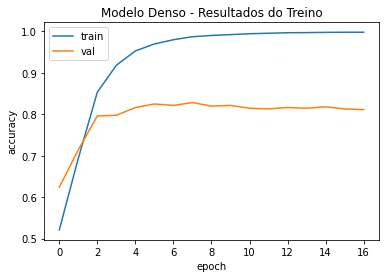

In [ ]:
plt.plot(dense_model_history.history['accuracy'])
plt.plot(dense_model_history.history['val_accuracy'])
plt.title('Modelo Denso - Resultados do Treino')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

A seguir, a matrix de confusão:

Acurácia do Modelo Denso: 0.8214285714285714


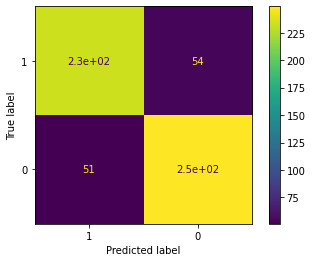

In [ ]:
y_test_hat_dense = np.round(dense_model.predict(X_test_preprocessed))[:,0]
# Acurácia na base de testes
dense_results = y_test == y_test_hat_dense
dense_accuracy = np.average(dense_results)
print(f"Acurácia do Modelo Denso: {dense_accuracy}")
confusion_matrix_dense = confusion_matrix(y_test, y_test_hat_dense)
disp_dense = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_dense,
                              display_labels=["1","0"])
disp_dense = disp_dense.plot()
plt.show()

Com os resultados obtidos, chegamos a valores maiores que o baseline estabelecido (Análise Naïve). Agora, tentaremos melhorar os resultados com um modelo sequencial (permitirá análise de consecução e não apenas do conjunto das palavras).

# Método 4: Rede Neural Recorrente com célula LSTM

O seguinte modelo fará uso da estrutura de Rede Neural Recorrente com células LSTM, as quais permitem aprender a relação entre valores em um contexto (através da análise consecutiva).

As células LSTM são conjuntos de funções e pesos que permitem guardar ou esquecer "informações" à medida que ocorre a aprendizagem. Isso permite uma análise rasa de contexto.

Isso por quê se trata de uma rede neural que corre de forma recorrente e linear: os estados em um tempo t estão atrelados aos estados no tempo t-1.

Apliquemos tal análise usando os mesmos dados preprocessados no modelo anterior:

In [ ]:
# Execute as linhas abaixo para limpar o modelo e recomeçar o treinamento do zero - para ajuste de parâmetros
#del lstm_model
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()

# Dessa vez vamos usar uma saída multiclasse com ativação softmax. Para isso, precisamos transformar os rótulos
# em valores categóricos, ou seja: 0 será [1, 0] e 1 será [0, 1] (2 classes).
one_hot_train_y = tf.keras.utils.to_categorical(y_train)
one_hot_test_y = tf.keras.utils.to_categorical(y_test)

# Criação de uma Rede Neural Recorrente com Células LSTM para análise de sentimento.
lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.Embedding(max_words, 100, input_length=max_len))
# Adicionamos dropout nas células LSTM para ajudar com o overfitting. 
# Dropout faz com que alguns pesos "zerem" durante o treinamento, reduzindo sobreajuste aos dados de treino.
lstm_model.add(tf.keras.layers.LSTM(15, dropout=0.2, recurrent_dropout=0.2))
# A última camada, ao invés de 1 nó com ativação sigmoid, usamos a ativação softmax, 
# que retorna uma "probabilidade" para cada classe.
lstm_model.add(tf.keras.layers.Dense(2, activation='softmax'))
lstm_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

# O treinamento será mais curto (10 épocas) pois o modelo fica sobreajustado muito rápido devido à escassez de dados.
lstm_model_history = lstm_model.fit(X_train_preprocessed, one_hot_train_y,
                                    batch_size=64, epochs=10,
                                    validation_data=(X_test_preprocessed, one_hot_test_y),
                                    callbacks=[scheduler_callback, early_stopping_callback])

Epoch 1/10
52/52 [==============================] - 12s 186ms/step - loss: 0.6844 - accuracy: 0.5479 - val_loss: 0.6311 - val_accuracy: 0.6956
Epoch 2/10
52/52 [==============================] - 9s 180ms/step - loss: 0.5480 - accuracy: 0.7715 - val_loss: 0.4994 - val_accuracy: 0.7432
Epoch 3/10
52/52 [==============================] - 9s 179ms/step - loss: 0.3452 - accuracy: 0.8560 - val_loss: 0.4095 - val_accuracy: 0.8044
Epoch 4/10
52/52 [==============================] - 9s 179ms/step - loss: 0.2087 - accuracy: 0.9318 - val_loss: 0.3890 - val_accuracy: 0.8265
Epoch 5/10
52/52 [==============================] - 9s 181ms/step - loss: 0.1387 - accuracy: 0.9579 - val_loss: 0.3961 - val_accuracy: 0.8282
Epoch 6/10
52/52 [==============================] - 9s 181ms/step - loss: 0.0974 - accuracy: 0.9765 - val_loss: 0.4119 - val_accuracy: 0.8350
Epoch 7/10
52/52 [==============================] - 9s 182ms/step - loss: 0.0634 - accuracy: 0.9855 - val_loss: 0.4593 - val_accuracy: 0.8316
Epoch

Vejamos o progresso do treinamento - note que rapidamente o modelo se sobreajusta e os resultados na base de avaliação começam a cair.

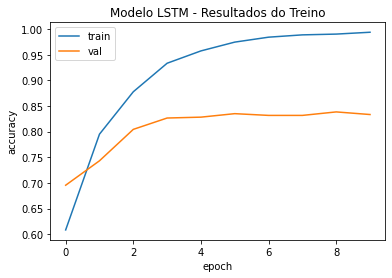

In [ ]:
plt.plot(lstm_model_history.history['accuracy'])
plt.plot(lstm_model_history.history['val_accuracy'])
plt.title('Modelo LSTM - Resultados do Treino')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Com as LSTM atingimos resultados um pouco melhores (83%~), em troca de maior tempo de treinamento. 

Entretanto, conforme verificado durante a elaboração do modelo LSTM, com a escassez de dados, os resultados não são muito melhores que modelos mais simples, pois o modelo se sobreajusta muito rápido.

Acurácia do Modelo LSTM: 0.8333333333333334


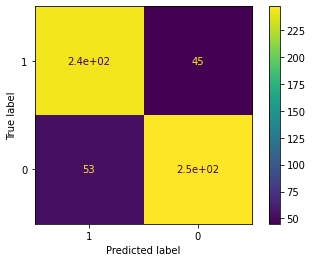

In [ ]:
y_test_hat_lstm = [np.argmax(x) for x in lstm_model.predict(X_test_preprocessed)]
# Acurácia na base de testes
lstm_results = y_test == y_test_hat_lstm
lstm_accuracy = np.average(lstm_results)
print(f"Acurácia do Modelo LSTM: {lstm_accuracy}")
confusion_matrix_lstm = confusion_matrix(y_test, y_test_hat_lstm)
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_lstm,
                              display_labels=["1","0"])


disp_lstm = disp_lstm.plot()
plt.show()

# Método 5: Finetuning BERT - Modelo baseado em atenção

Finalmente chegamos ao último modelo testado. Usaremos a Arquitetura BERT - Bidirectional Encoder Representations from Transformers, uma inovação apresentada pelo Google em 2018 que inclui um modelo baseado em Transformers, que são uma arquitetura que permite a análise sequencial de forma paralela.

Um dos mecanismos utilizados no BERT é o mecanismo de "Atenção" - esse mecanismo permite que determinadas palavras "prestem atenção" a outras durante o treinamento, dependendo do modelo utilizado. Por ser um modelo bidirecional, o BERT permite que palavras prestem atenção a suas antecessoras e sucessoras.

Com isso, é possível realizar uma profunda análise de contexto de forma paralela.

O BERT foi treinado em dados massivos e seus pesos são disponibilizados publicamente. Um meio de acessar esses pesos é utilizando a biblioteca "Transformers".

Iremos realizar o chamado "finetuning", que seria uma "afinação" do modelo aos nossos dados. Ou seja, adaptamos o modelo mais geral à nossa necessidade específica.

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.5MB 8.4MB/s 
     |████████████████████████████████| 2.9MB 20.0MB/s 
     |████████████████████████████████| 890kB 37.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=633219effa50d3528053cda18246373a1a8f35433cc79bb2f9934ae850158e3d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


Para iniciar, precisamos realizar o preprocessamento do texto. Para isso, precisamos usar o conjunto de tokens e embedding utilizados no modelo pré-treinado.

Vamos utilizar o DistilBert, que é uma versão "light" do BERT, capaz de ser processada no Google Colab.

In [ ]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

X_train_bert = tokenizer(list(X_train.values),                      
                        truncation=True,
                        padding=True)
              
X_test_bert = tokenizer(list(X_test.values),                      
                        truncation=True,
                        padding=True)

A seguir, fazemos uma adaptação dos dados tokenizados ao formato do Tensorflow, para uso em um modelo Keras.

In [ ]:
bert_train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(X_train_bert),
    y_train
))
bert_test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(X_test_bert),
    y_test
))

In [ ]:
from transformers import TFDistilBertForSequenceClassification
import tensorflow as tf

# Estabelecemos uma learning rate bem baixa, para não mudar demais os pesos pre-treinados
learning_rate = 5e-5
# Apenas uma época é suficiente para excelentes resultados, até por quê esses modelos se sobreajustam muito facilmente.
number_of_epochs = 1
# Ah, 1 época em um kernel normal leva cerca de 2h e 30 min para treinar.

# Inicialização do modelo - usamos o número de labels igual a 2.
BERT_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Mais uma vez usamos o Adam como optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)

# Para realizar o treinamento, usamos a SparseCategoricalCrossentropy, para 2 classes.
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
# Finalmente compilamos o modelo, que será um modelo compatível com Keras.
BERT_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'activation_13', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_19', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
# Executar essa célula demora cerca de 2h e 30 min.
bert_history = BERT_model.fit(bert_train_dataset.shuffle(100).batch(16),
                            batch_size=16,
                            epochs=number_of_epochs, 
                            validation_data=bert_test_dataset.shuffle(100).batch(16))

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


208/208 [==============================] - ETA: 0s - loss: 0.4544 - accuracy: 0.7875 

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


208/208 [==============================] - 10420s 50s/step - loss: 0.4538 - accuracy: 0.7879 - val_loss: 0.2068 - val_accuracy: 0.9116


In [ ]:
# Salvando o modelo. 2h e 30 min são preciosos
BERT_model.save_pretrained('/content/')

In [ ]:
# Carregando o modelo
import os.path
if not os.path.exists("/content/bert/"):
    os.makedirs("/content/bert/")
if not os.path.exists("/content/bert/tfmodel.h5"):
    !wget https://storage.googleapis.com/dl_models/tf_model.h5 -P /content/bert/
    !wget https://storage.googleapis.com/dl_models/config.json -P /content/bert/
BERT_model = TFDistilBertForSequenceClassification.from_pretrained("/content/bert/")

--2020-12-23 11:25:55--  https://storage.googleapis.com/dl_models/tf_model.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.128, 74.125.195.128, 74.125.28.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 267952712 (256M) [application/octet-stream]
Saving to: ‘/content/bert/tf_model.h5.1’

tf_model.h5.1       100%[===================>] 255.54M   206MB/s    in 1.2s    

2020-12-23 11:25:56 (206 MB/s) - ‘/content/bert/tf_model.h5.1’ saved [267952712/267952712]

--2020-12-23 11:25:56--  https://storage.googleapis.com/dl_models/config.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 74.125.195.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 488 [application/json]
Saving to: ‘/content/bert/config.js

Some layers from the model checkpoint at /content/bert/ were not used when initializing TFDistilBertForSequenceClassification: ['dropout_77']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/bert/ and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Agora que o modelo foi carregado, podemos vê-lo em funcionamento:

In [ ]:
# Escreva o que quiser abaixo (em inglês) 
test_sentence = "I loved this movie casting. I also liked the soundtrack, but the story is awful, I do not recomend"
# O tokenizer será usado para transformar a sentença no formato que o BERT entende.
predict_input = tokenizer.encode(test_sentence,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")
# Realizamos a predição e escolhemos o primeiro resultado
results = BERT_model.predict(predict_input)[0]
# Aplicamos o softmax na saída - retornará a probabilidade dos resultados para a primeira posição
tf_prediction = tf.nn.softmax(results, axis=1).numpy()[0]
# Extraímos o resultado mais provável com argmax (retorna a posição 0 ou 1)
print("O sentimento é: {}".format("Positivo" if np.argmax(tf_prediction) else "Negativo"))
# P.S.: A primeira execução demora mais

O sentimento é: Negativo


Perceba que, no geral, o BERT consegue dar respostas corretas inclusive para sentenças complexas. Passemos agora para a análise dos resultados.

Acurácia do Modelo BERT: 0.9115646258503401


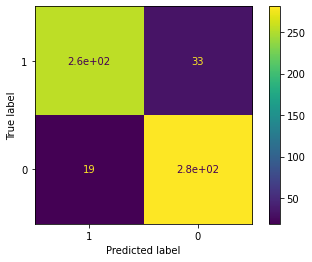

In [ ]:
tokenized_test = [tokenizer.encode(sent,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf") for sent in X_test]
bert_logits = [BERT_model.predict(tokenized) for tokenized in tokenized_test]
y_test_hat_bert = [np.argmax(tf.nn.softmax(x[0], axis=1)[0]) for x in bert_logits]
# Acurácia na base de testes
bert_results = y_test == y_test_hat_bert
bert_accuracy = np.average(bert_results)
print(f"Acurácia do Modelo BERT: {bert_accuracy}")
confusion_matrix_bert = confusion_matrix(y_test, y_test_hat_bert)
disp_bert = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_bert,
                              display_labels=["1","0"])


disp_bert = disp_bert.plot()
plt.show()

91% de acurácia não é nada mau para apenas 1 época de treinamento e poucos dados.

# Comparativo de Modelos

Comparemos agora os modelos e os resultados:

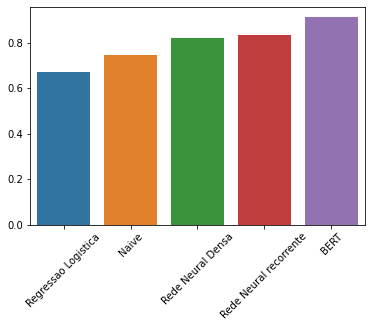

In [ ]:
all_accuracy = {"Naive": naive_sa_accuracy, "Regressao Logistica": logreg_accuracy, 
                "Rede Neural Densa": dense_accuracy, "Rede Neural recorrente": lstm_accuracy,
                "BERT": bert_accuracy}
all_accuracy = dict(sorted(all_accuracy.items(), key=lambda item: item[1]))
keys = list(all_accuracy.keys())
vals = [all_accuracy[k] for k in keys]
sns.barplot(x=keys, y=vals)
plt.xticks(rotation=45)
plt.show()

Finalmente, um comparativo das matrizes de confusão:

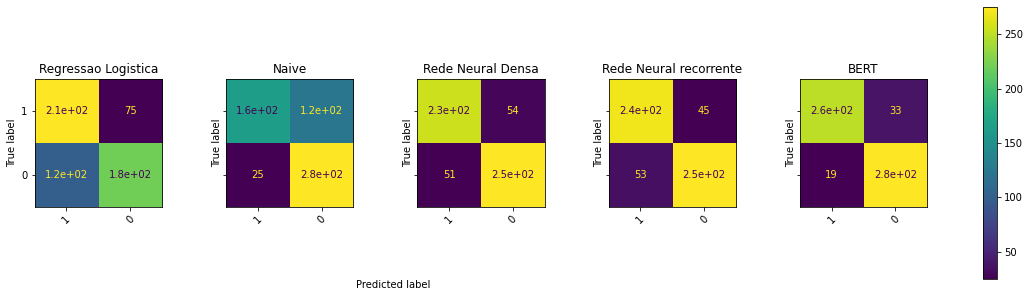

In [ ]:
f, axes = plt.subplots(1, 5, figsize=(20, 5), sharey='row')

confusion_matrices = {"Regressao Logistica": disp_logreg, "Naive": disp, 
                      "Rede Neural Densa": disp_dense, "Rede Neural recorrente": disp_lstm,
                      "BERT": disp_bert}
curr_key = 0
for key, display in confusion_matrices.items():
    display.plot(ax=axes[curr_key], xticks_rotation=45)
    display.ax_.set_title(key)
    display.im_.colorbar.remove()
    display.ax_.set_xlabel('')
    curr_key+=1

f.text(0.4, 0.1, 'Predicted label', ha='right')
plt.subplots_adjust(wspace=0.50, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()
